29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step 
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


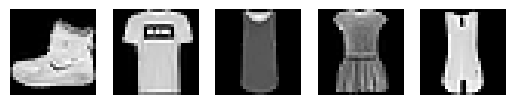

In [5]:
# %% veri seti yuklemesi and preprocessing
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# load data
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# normaliztion
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float")/255.0

# gorsellestirme
plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap = "gray")
    plt.axis("off")
plt.show()

# veriyi duzlestir 28x28 boyutundaki goruntuleri 784 boyutunca bir vektore donusturur
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [17]:
# %% encoder ve decoder mimarisi olusturma, autoencoders = encoder + decoder, training

# autoencoder icin model parametrelerin tanimlanmasi
input_dim = x_train.shape[1]
encoding_dim = 64 # latent boyutu veriyi kuculttukten sonra elde ettigimiz veri parcsinin boyutu

# encoder
input_image = Input(shape = (input_dim,)) # girdi boyutunu belirleme 784
encoded = Dense(256, activation = "relu")(input_image) # ilk gizli katman 256 noron
encoded = Dense(128, activation = "relu")(encoded) # ikinci gizli katman 128 noron
encoded = Dense(encoding_dim, activation = "relu")(encoded) #sikistirma katmani latent space

# decoder
decoded = Dense(128, activation = "relu")(encoded) #ilk genisleme katmani 128
decoded = Dense(256, activation = "relu")(decoded) # ikincş genisleme katmani 256
decoded = Dense(input_dim, activation = "sigmoid") (decoded)# cikti katmani 784 boyutlu

# autoencoders
autoencoder = Model(input_image, decoded) # giristen ciktiya tum yapiyi tanimliyoruz

# compile
autoencoder.compile(optimizer = Adam(), loss = "binary_crossentropy")

# training
history = autoencoder.fit(
    x_train, #girdi ve hedef (target) ayni deger olmali (otonom ogrenme)
    x_train,
    epochs = 50,
    batch_size = 64,
    shuffle = True, # egitim verilerini karistir
    validation_data = (x_test, x_test),
    verbose = 1,
)

"""
1.training sonuclari (orta seviye): loss: 0.2619 - val_loss: 0.2651
2.training sonuclari (karmasik): loss: 0.2619 - val_loss: 0.2653
3.training sonuclari (sig): loss: 0.2865 - val_loss: 0.2891
"""

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3618 - val_loss: 0.2947
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2909 - val_loss: 0.2857
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2823 - val_loss: 0.2816
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2790 - val_loss: 0.2789
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.2763 - val_loss: 0.2775
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2745 - val_loss: 0.2756
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.2728 - val_loss: 0.2742
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2714 - val_loss: 0.2738
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2704 - val_loss: 0.2734
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.2696 - val_loss: 0.2725
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2696 - val_loss: 0.2712
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


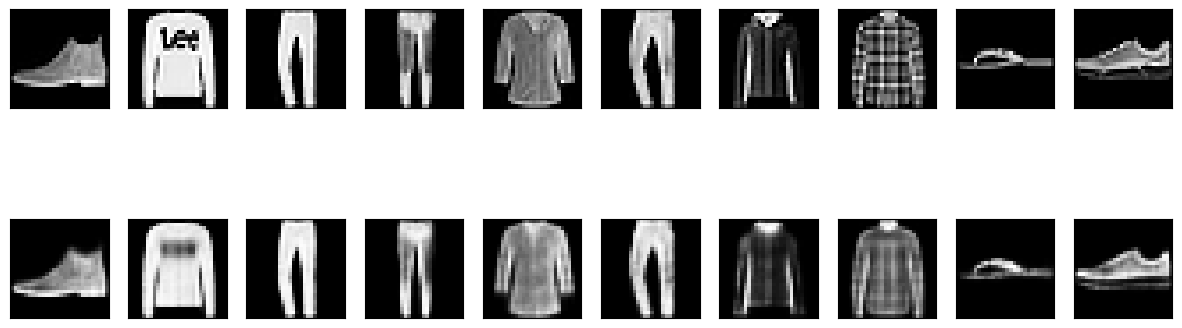

In [23]:
# %% model test and evaluation: PSNR degerlendirme metrik

# modeli encoder ve decoder olmak uzere ikiye ayiralim
# encoder 
encoder = Model(input_image, encoded)

# decoder
encoded_input = Input(shape = (encoding_dim,))
decoder_layer1 = autoencoder.layers[-3](encoded_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_output = autoencoder.layers[-1](decoder_layer2)

decoder = Model(encoded_input, decoder_output)

# test verisi kullanarak encoder ile sikistiralim ve decoder ile yeniden yapilandiralim
encoded_images = encoder.predict(x_test) # latent temsili haline getir yani sikistirma
decoded_images = decoder.predict(encoded_images) #latent temsilinden orijinal formata geri cevirme

# orijinal ve yeniden yapilandirilan (decoded_images) goruntuleri gorsellestir
n = 10 # 10 sample

plt.figure(figsize = (15,5))
for i in range(n):

    # orijinal boyutu
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28), cmap = "gray")
    ax.get_xaxis().set_visible(False) # x eksenini gizliyoruz
    ax.get_yaxis().set_visible(False) # y eksenini gizliyoruz

    # decoded_image yani yeniden yapilandirilmis goruntu
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28,28), cmap = "gray")
    ax.get_xaxis().set_visible(False) # x eksenini gizliyoruz
    ax.get_yaxis().set_visible(False) # y eksenini gizliyoruz

plt.show()